<hr>

### imbalanced-learn 라이브러리는 Scikit-learn을 비롯해 많은 라이브러리들의 버전에 영향을 줍니다.<br><br>-> <span style="color:red;">Colab에서 실습을 진행</span>하는 것을 권장합니다. (혹은 Conda 가상환경 활용)


<br>

\* Original source @ https://www.kaggle.com/dogdriip/iqr-outlier-smote-oversampling/notebook 

<hr>

**본 실습에서 다뤄지는 신용카드 데이터셋의 경우 심한 class-imbalance 상태임**
<br>- class 0 == 정상적인 신용카드 거래 데이터 
<br>- class 1 == 사기 신용카드 거래 데이터
<br>전체 데이터셋 중 **0.1715% 만이 class 1 (사기거래) 데이터**

<br> 일반적으로 **Fraud detection & Anomaly detection** 의 대상이 되는 데이터셋의 경우 
<br> 이처럼 class-imbalanced data인 경우가 많음 (Fraud or Anomaly 자체가 극히 드물게 발생하기 때문)

<br>
<br>

# 1. 필수 라이브러리 install & import

### 1) LightGBM 설치

In [ ]:
!pip install lightgbm==3.3.2

# "액세스가 거부되었습니다" 에러 발생 시,
# cmd(명령프롬프트) 우클릭 & 관리자권한으로 실행 후,
# "pip install lightgbm==3.3.2"를 입력 및 실행하여 설치를 진행합니다.

### 2) Imbalanced-learn (imblearn) 설치

- (로컬 환경에서 진행 시) **cmd(명령프롬프트) 우클릭 & 관리자권한 실행** 후, 아래 명령어를 입력해 설치를 진행합니다.
<br>
- 에러가 발생할 경우 뒷 부분의 버전 정보("==0.7.0")를 제외해주세요.

> <span style="color:red;">**conda install -c conda-forge imbalanced-learn==0.7.0**</span>

In [125]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings                 
warnings.filterwarnings('ignore')

<br>
<br>

# 2. 데이터 로드 및 전처리

In [151]:
# 데이터 출처 : Credit Card Fraud Detection @ https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

card_df = pd.read_csv('creditcard.csv')
card_df.shape

(284807, 31)

In [127]:
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Time : Number of seconds elapsed between this transaction and the first transaction in the dataset
- V1~V28 : may be result of a PCA Dimensionality reduction to protect **user identities and sensitive features** 
- Amount : Transaction amount
- Class : 1 for fraudulent transactions (사기 거래), 0 otherwise (정상 거래)

In [152]:
card_df = card_df.drop('Time', axis=1)

<AxesSubplot:xlabel='Amount', ylabel='Density'>

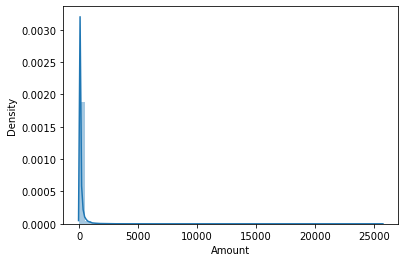

In [153]:
sns.distplot(card_df['Amount'])

<AxesSubplot:xlabel='Amount', ylabel='Density'>

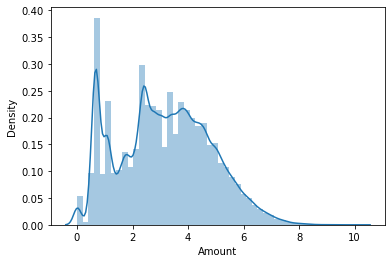

In [154]:
# 로그변환과 np.log()가 아닌 np.log1p()를 하는 이유 @ https://suppppppp.github.io/posts/Why-Series-MDM-1/

sns.distplot(np.log1p(card_df['Amount']))

In [155]:
card_df['Amount'] = np.log1p(card_df['Amount'])

<br>
<br>

# 3. Outlier 탐지 및 제거

**본 데이터셋과 같이 Feature의 수가 무척 많을 경우, <span style="color:red;"><b>Label(Target) 열과 가장 높은 상관관계를 갖고 있는 Feature들</b></span>을 위주로 Outlier handling을 진행해주는 것이 좋음**

<br>
- 모든 Feature를 대상으로 이상치 검출 & 제거를 하는 경우 많은 시간이 소모됨
<br>- 모든 Feature를 대상으로 이상치 검출 & 제거를 하는 경우 과도하게 많은 행이 삭제될 수 있음
<br>- Label(Target) 열과 낮은 상관관계를 갖고 있는 Feature들의 경우 이상치 제거를 하더라도 결과적인 모델 성능 향상이 미미함

<AxesSubplot:>

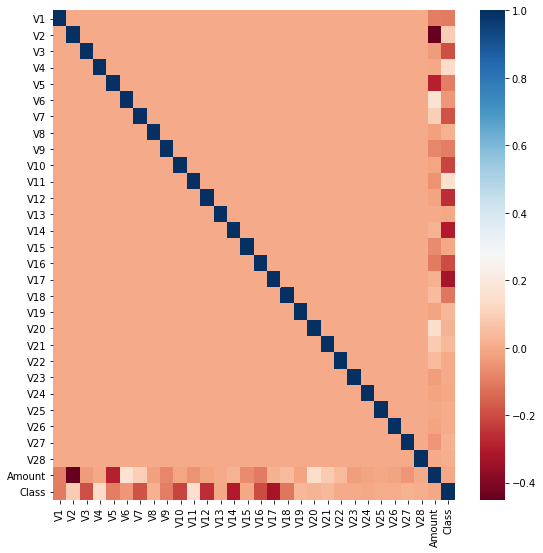

In [132]:
plt.figure(figsize=(9, 9))
sns.heatmap(card_df.corr(), cmap='RdBu')

In [133]:
# Correlation dataframe 기준 최하단 "Class" 행에서 가장 절대값이 큰 상관관계를 보이는 feature 찾기

card_df.corr().loc['Class'].sort_values()

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Amount   -0.008326
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

In [162]:
outlier_index = []

for col in ['V14', 'V17']:
    
    # 전체 데이터프레임을 대상으로 outlier 제거 시, class 1 기준 행의 수가 492개에서 47개로 줄어들어버립니다.
    df_fraud = card_df[card_df['Class'] == 1] 
    
    quantile_25 = df_fraud[col].quantile(0.25)
    quantile_75 = df_fraud[col].quantile(0.75)
    iqr = quantile_75 - quantile_25

    outlier_df = df_fraud[(df_fraud[col] < quantile_25 - iqr * 1.5) | (df_fraud[col] > quantile_75 + iqr * 1.5) ]
    outlier_index = outlier_index + list(outlier_df.index)

print(outlier_index)

[8296, 8615, 9035, 9252]


In [135]:
card_df = card_df.drop(outlier_index)

<br>
<br>

# 4. SMOTE를 활용한 Over-sampling 적용

<hr>

### imbalanced-learn 라이브러리는 Scikit-learn을 비롯해 많은 라이브러리들의 버전에 영향을 줍니다.<br><br>-> <span style="color:red;">Colab에서 실습을 진행</span>하는 것을 권장합니다. (혹은 Conda 가상환경 활용)

<hr>

Class-imbalance가 심한 데이터셋을 활용할 시, 
<br>**무조건 대다수 데이터가 포함된 class를 선택하는 방식**으로 모델이 잘못 학습될 수 있습니다. (다수 데이터 class에 치우친 학습 진행)

이 경우, 적은 수의 데이터가 포함된 class의 데이터 양을 늘려주는 방법(over-sampling)을 적용해볼 수 있습니다.
<br>기본적으로 Over-sampling 기법들은 원본 데이터의 값을 살짝씩 변경해 새로운 데이터를 생성하는 방식으로 작동합니다.

저희가 활용할 <span style="color:red;">**SMOTE(Synthetic Minority Over-sampling Technique)**</span> 기법은
<br>- 적은 수의 데이터가 포함된 class의 개별 데이터들에 대하여 K-Nearest-Neighbor들을 찾아, 
<br>- 원본 데이터와 K개 최근접 이웃 사이의 차이를 일정 값으로 만들어, 
<br>- **기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성**하는 방식으로 작동합니다.

## 1) train-test split

**SMOTE를 적용할 때는 반드시 <span style='color:red;'><b>학습 데이터 세트만 오버 샘플링</b></span>을 해야 합니다.** 

In [156]:
x_data = card_df.copy()
del x_data['Class']

y_data = card_df['Class']

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.3, 
                                                    stratify=y_data)

In [137]:
print('[ Train y ]')
print(y_train.value_counts())
print(y_train.value_counts() / y_train.shape[0] * 100)
print()

print('[ Test y ]')
print(y_test.value_counts())
print(y_test.value_counts() / y_test.shape[0] * 100)

[ Train y ]
0    199020
1       342
Name: Class, dtype: int64
0    99.828453
1     0.171547
Name: Class, dtype: float64

[ Test y ]
0    85295
1      146
Name: Class, dtype: int64
0    99.829122
1     0.170878
Name: Class, dtype: float64


## 2) SMOTE 기반 Over-sampling

In [159]:
from imblearn.over_sampling import SMOTE

In [160]:
smote = SMOTE(random_state=42)

X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

In [144]:
print('SMOTE-sampling 적용 전 :', X_train.shape, y_train.shape)
print('SMOTE-sampling 적용 후 :', X_train_over.shape, y_train_over.shape)

SMOTE-sampling 적용 전 : (199362, 29) (199362,)
SMOTE-sampling 적용 후 : (398040, 29) (398040,)


In [147]:
print('SMOTE-sampling 적용 전 :')
print(y_train.value_counts())
print()

print('SMOTE-sampling 적용 후 :')
print(y_train_over.value_counts())

SMOTE-sampling 적용 전 :
0    199020
1       342
Name: Class, dtype: int64

SMOTE-sampling 적용 후 :
0    199020
1    199020
Name: Class, dtype: int64


<br>
<br>

# 5. Model training & evaluation (Light-GBM 활용)

In [163]:
from lightgbm import LGBMClassifier
from sklearn import metrics 

### 1) **without** over-sampling 

In [149]:
model_without_smote = LGBMClassifier(n_estimators=1000, 
                                       num_leaves=64, 
                                       boost_from_average=False)

model_without_smote.fit(X_train, y_train) # Over-sampling 적용 전

pred = model_without_smote.predict(X_test)
pred_proba = model_without_smote.predict_proba(X_test)[:, 1]

confusion = metrics.confusion_matrix(y_test, pred)
accuracy = metrics.accuracy_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
roc_auc = metrics.roc_auc_score(y_test, pred_proba)

print('Confusion matrix:')
print(confusion)
print()

print('Accuracy :', accuracy)
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)
print('ROC_AUC :', roc_auc)

Confusion matrix:
[[85291     4]
 [   31   115]]

Accuracy : 0.9995903605997121
Precision : 0.9663865546218487
Recall : 0.7876712328767124
F1 : 0.8679245283018869
ROC_AUC : 0.97819565777756


### 2) **with** over-sampling 

### Over-sampling 이후

In [150]:
model_with_smote = LGBMClassifier(n_estimators=1000, 
                                  num_leaves=64, 
                                  boost_from_average=False)

model_with_smote.fit(X_train_over, y_train_over) # Over-sampling 적용 후

pred = model_with_smote.predict(X_test)
pred_proba = model_with_smote.predict_proba(X_test)[:, 1]

confusion = metrics.confusion_matrix(y_test, pred)
accuracy = metrics.accuracy_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
roc_auc = metrics.roc_auc_score(y_test, pred_proba)

print('Confusion matrix:')
print(confusion)
print()

print('Accuracy :', accuracy)
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)
print('ROC_AUC :', roc_auc)

Confusion matrix:
[[85275    20]
 [   26   120]]

Accuracy : 0.999461616788193
Precision : 0.8571428571428571
Recall : 0.821917808219178
F1 : 0.8391608391608392
ROC_AUC : 0.9784783993023407


> SMOTE 기반 Over-sampling 적용 결과,
<br>
<br>-> **Class 1** 데이터 증대
<br>-> **실제 Class 값이 1 인 데이터** 중 **model 이 class 1 으로 잘 맞춰낸 비율**인 <span style='color:red;'>**Recall 상승**</span>
<br><br> ※ 일반적으로 <span style="color:blue;">Recall & Precision은 Trade-off 관계가 있음</span>

<br>
<br>

### cf) IQR 기반 이상치 제거를 하지 않았을 경우의 결과

In [164]:
# over-sampling 적용 X

Confusion matrix:
[[85286     9]
 [   30   118]]

Accuracy : 0.9995435553526912
Precision : 0.9291338582677166
Recall : 0.7972972972972973
F1 : 0.8581818181818182
ROC_AUC : 0.9791850382535652


In [165]:
# over-sampling 적용 O

Confusion matrix:
[[85271    24]
 [   30   118]]

Accuracy : 0.9993679997191109
Precision : 0.8309859154929577
Recall : 0.7972972972972973
F1 : 0.8137931034482759
ROC_AUC : 0.9765384999279132
